# Nitrogen thresholds into Acidification Potential Thresholds
This translates each ecoreigon threshold into an acidification potential threshold. It divides total nitrogen deposition into NH3 and NOx, calculate average for each ecoregion, and divides the threshold according to that average. It then apply each LEAF into it and voila

## Nitrogen breakdown

In [1]:
import polars as pl
import geopandas as gpd
import sbtn_leaf.map_plotting as mplot
import sbtn_leaf.map_calculations as mc


Could not determine dtype for column 1, falling back to string


Select needed files for 2020


In [2]:
tot_NOy_fp = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNOy_2020_hm.tif"
tot_NHx_fp = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNHx_2020_hm.tif"
tot_N_fp   = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif"

Checking total N depositions

In [3]:
mplot.inspect_raster(tot_N_fp)

File: ../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif
Driver: GTiff
Width, Height: 2307, 1430
Number of Bands: 1
CRS: PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",105],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",47],PARAMETER["false_easting",4000000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-12754690.136988254, bottom=-4121276.274192298, right=20764251.306624927, top=16655527.481493374)
Pixel Size: (14529.233395584386, 14529.233395584386)
No-data Value: -3.4028234663852886e+38

--- Raster Metadata ---
DataType: Generic
AREA

Raster has 475,006 unique values. Min: 0.00. Max: 67.28
Using quantiles
All positives route (quantiles)


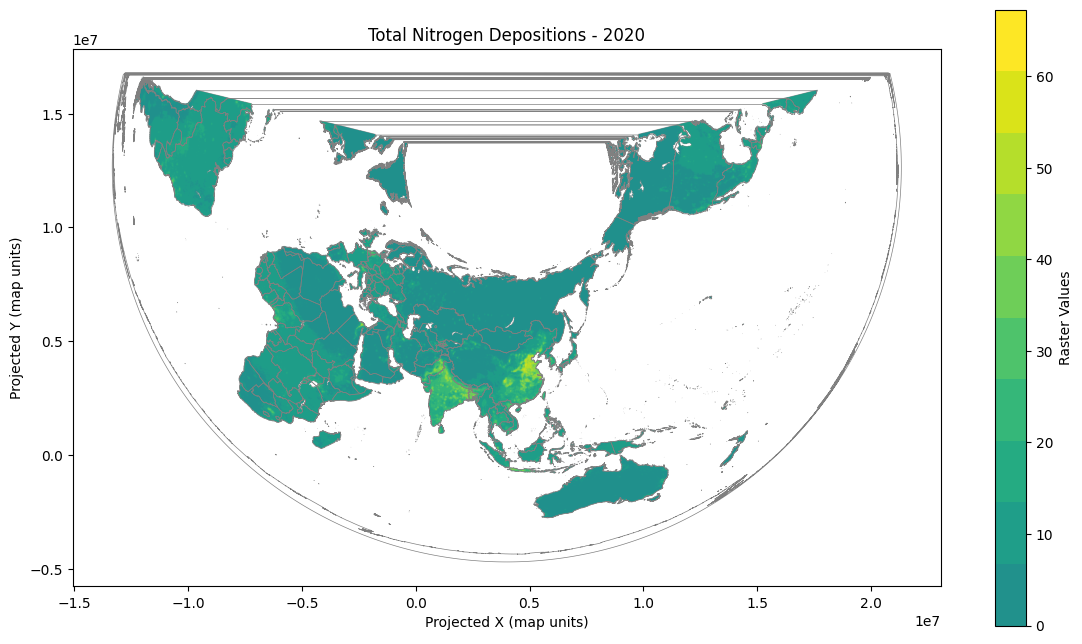

In [4]:
mplot.plot_raster_on_world_extremes_cutoff(tot_N_fp, "Total Nitrogen Depositions - 2020", perc_cutoff=0, quantiles=10)

Creating a 10-year average

In [5]:
import numpy as np
import rasterio

def decade_mean(prefix: str, years=range(2011, 2021)):
    paths = [
        f"../thresholds/Global_N_deposition_grid_dataset_2008_2020/{prefix}_{yr}_hm.tif"
        for yr in years
    ]
    with rasterio.open(paths[0]) as src0:
        meta = src0.meta.copy()
        sum_arr = np.zeros(src0.shape, dtype="float64")
        count = np.zeros(src0.shape, dtype="int16")
        nodata = src0.nodata

    for fp in paths:
        with rasterio.open(fp) as src:
            arr = src.read(1)
            mask = arr != nodata
            sum_arr[mask] += arr[mask]
            count[mask] += 1

    mean_arr = np.divide(sum_arr, count, out=np.zeros_like(sum_arr), where=count > 0)
    nodata_value = nodata if nodata is not None else np.nan
    mean_arr[count == 0] = nodata_value
    meta.update(dtype="float32", nodata=nodata)

    out_fp = f"../thresholds/{prefix}_2011_2020_mean.tif"
    
    with rasterio.open(out_fp, "w", **meta) as dst:
        dst.write(mean_arr.astype("float32"), 1)
    return out_fp

In [6]:
# Build averaged rasters
tot_N_fp = decade_mean("mean_totN")
tot_NHx_fp = decade_mean("mean_totNHx")
tot_NOy_fp = decade_mean("mean_totNOy")

Transforming

In [7]:
tot_N_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_N_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_N",
    area_type="ecoregion"
)

2025-11-18 11:19:56,655 - INFO - Starting: Calculating ecoregion weighted CF for tot_N without outlier filtering
2025-11-18 11:29:29,778 - INFO - Calculations complete for ../thresholds/mean_totN_2011_2020_mean.tif! Found matches for 779 regions.



In [8]:
tot_NHx_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_NHx_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_NHx",
    area_type="ecoregion"
)

2025-11-18 11:29:29,917 - INFO - Starting: Calculating ecoregion weighted CF for tot_NHx without outlier filtering
2025-11-18 11:36:36,099 - INFO - Calculations complete for ../thresholds/mean_totNHx_2011_2020_mean.tif! Found matches for 779 regions.



In [9]:
tot_NOy_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_NOy_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_NOy",
    area_type="ecoregion"
)

2025-11-18 11:36:36,161 - INFO - Starting: Calculating ecoregion weighted CF for tot_NOy without outlier filtering
2025-11-18 11:40:25,829 - INFO - Calculations complete for ../thresholds/mean_totNOy_2011_2020_mean.tif! Found matches for 779 regions.



In [10]:
tot_N_er_gdf = tot_N_er_results[1]
tot_NHx_er_gdf = tot_NHx_er_results[1]
tot_NOy_er_gdf = tot_NOy_er_results[1]

<Axes: >

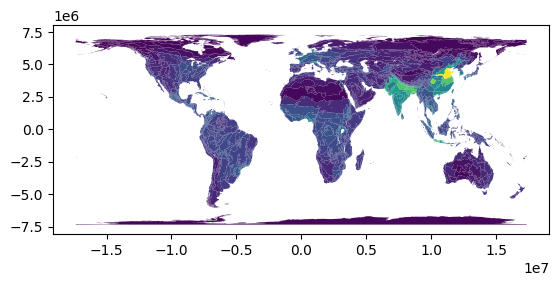

In [11]:
tot_N_er_gdf.plot(column = "cf")

Which looks ok. Now massaging the gdf to merge them

In [13]:
tot_N_er_gdf

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,er_id,er_name,Biome,imp_cat,flow_name,unit,cf,cf_median,cf_std
0,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",135.0,Admiralty Islands lowland rain forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,8.209746,8.173039,0.560544
2,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",785.0,Aegean and Western Turkey sclerophyllous and m...,"Mediterranean Forests, Woodlands & Scrub",N depositions,tot_N,kg N/ha,8.589867,7.712928,2.519025
3,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,807,"MULTIPOLYGON (((6318553.57 4168604.183, 632262...",807.0,Afghan Mountains semi-desert,Deserts & Xeric Shrublands,N depositions,tot_N,kg N/ha,5.005164,4.930552,1.067038
4,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,404,"MULTIPOLYGON (((-15463281.201 6262077.155, -15...",404.0,Ahklun and Kilbuck Upland Tundra,Tundra,N depositions,tot_N,kg N/ha,0.545915,0.424577,0.548559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,848.0,Sulawesi lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,156,"MULTIPOLYGON (((11320842.132 -958323.804, 1131...",156.0,Sulawesi lowland rain forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,9.335797,8.397769,2.967481
843,212.0,East African montane forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,8,"MULTIPOLYGON (((3544664.721 -399111.126, 35446...",8.0,East African montane forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,14.291216,14.075237,4.904296
844,224.0,Eastern Arc forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,9,"MULTIPOLYGON (((3510170.876 -1139262.003, 3510...",9.0,Eastern Arc forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,9.274610,9.328257,0.771901
845,79.0,Borneo montane rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Indomalayan,IN01,220,"MULTIPOLYGON (((10885961.971 -64628.237, 10885...",220.0,Borneo montane rain forests,Tropical & Subtropical Moist Broadleaf Forests,N depositions,tot_N,kg N/ha,8.754706,8.657533,1.307348


In [14]:
tot_N_er_gdf = tot_N_er_gdf.drop(columns=["er_id","er_name", "Biome", "flow_name", ])
tot_NHx_er_gdf = tot_NHx_er_gdf.drop(columns=["er_id","er_name", "Biome", "imp_cat", "flow_name", "unit"])
tot_NOy_er_gdf = tot_NOy_er_gdf.drop(columns=["er_id","er_name", "Biome", "imp_cat", "flow_name", "unit"])

In [15]:
tot_N_er_gdf = tot_N_er_gdf.rename(columns={
    "cf": "N_avg",
    "cf_median": "N_med",
    "cf_std": "N_std",
})

tot_NHx_er_gdf = tot_NHx_er_gdf.rename(columns={
    "cf": "NHx_avg",
    "cf_median": "NHx_med",
    "cf_std": "NHx_std",
})

tot_NOy_er_gdf = tot_NOy_er_gdf.rename(columns={
    "cf": "NOy_avg",
    "cf_median": "NOy_med",
    "cf_std": "NOy_std",
})

In [16]:
drop_columns = ["ECO_NAME",	"BIOME_NUM", "BIOME_NAME", "REALM",	"ECO_BIOME_", "OBJECTID", "geometry"]

In [17]:
all_N_er_gdf = tot_N_er_gdf.merge(
    tot_NHx_er_gdf.drop(columns=drop_columns),
    on = "ECO_ID",
    how = "left"
).merge(
    tot_NOy_er_gdf.drop(columns=drop_columns),
    on = "ECO_ID",
    how = "left"
)

Now calculating the NHx and NOy breakdown

In [18]:
all_N_er_gdf['NHx_perc'] = all_N_er_gdf.apply(
    lambda row: row['NHx_avg'] / row['N_avg'] if row['N_avg'] != 0 else None,
    axis=1
)

all_N_er_gdf['NOy_perc'] = all_N_er_gdf.apply(
    lambda row: row['NOy_avg'] / row['N_avg'] if row['N_avg'] != 0 else None,
    axis=1
)

all_N_er_gdf['N_perc_check'] = all_N_er_gdf.apply(
    lambda row: round(row['NHx_perc'] + row['NOy_perc'],2) if row['NOy_perc'] != 0 else None,
    axis=1
)

Checking all values add up to 100%

In [19]:
all_N_er_gdf[(all_N_er_gdf["N_perc_check"] != 1.0) & (all_N_er_gdf["N_perc_check"].notna())].shape[0]

0

Which they do.

Quickly plotting percentage of NHx emissions...

<Axes: >

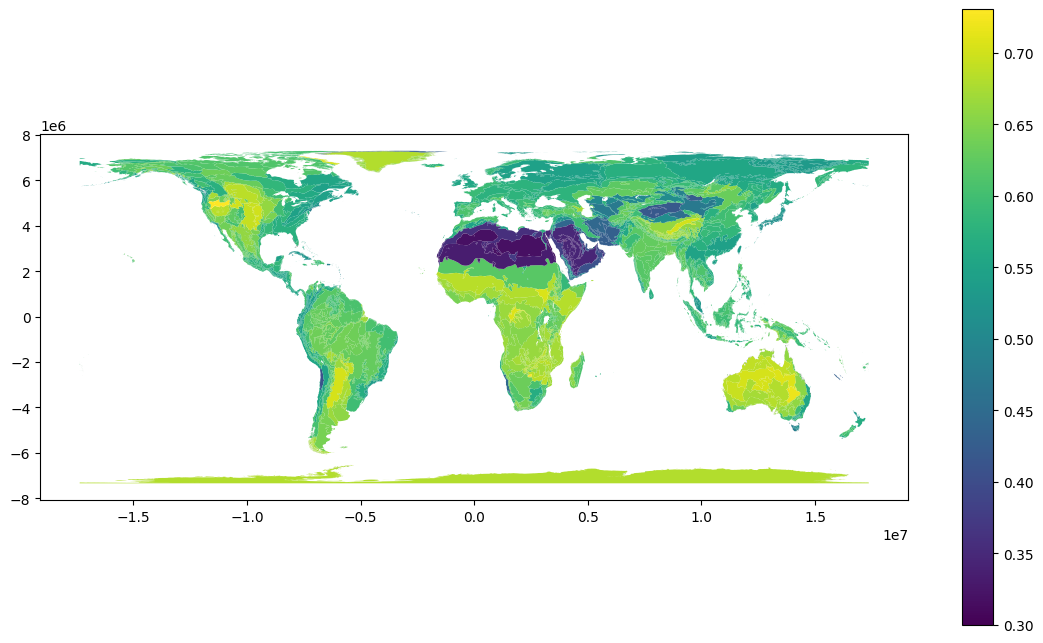

In [20]:
all_N_er_gdf.plot(column="NHx_perc", legend = True, figsize = (14,8))

## Nitrogen Thresholds import

Loading the thresholds

In [21]:
N_thresholds = pl.read_csv("../thresholds/acid_thresholds.csv")

Checking the file

In [22]:
N_thresholds.head(5)

ECO ID,Ecoregion name,Threshold,Ecoregion baseline,Target (10% above threshold),Threshold exceedance,Difference between baseline and target,Threshold met or exceeded? (Y/N)
i64,str,f64,str,f64,str,str,str
1,"""Albertine Rift montane forests""",20.0,"""13.8""",18.0,"""-6.2""","""-4.2""","""No"""
2,"""Cameroon Highlands forests""",20.0,"""16.5""",18.0,"""-3.5""","""-1.5""","""No"""
3,"""Central Congolian lowland fore…",14.2,"""14.1""",12.78,"""-0.1""","""1.32""","""No"""
4,"""Comoros forests""",20.0,"""2.2""",18.0,"""-17.8""","""-15.8""","""No"""
5,"""Congolian coastal forests""",9.8,"""11.9""",8.82,"""2.1""","""3.08""","""Yes"""


Selecting needed columns and merging them into the gdf

In [23]:
N_thresholds = N_thresholds["ECO ID", "Threshold", "Ecoregion baseline"]

In [24]:
N_thresholds_breakdown_gdf = all_N_er_gdf.merge(N_thresholds.to_pandas(), how="left", left_on="ECO_ID", right_on="ECO ID")

Now filtering out the ones without thresholds

In [25]:
N_thresholds_breakdown_gdf = N_thresholds_breakdown_gdf[N_thresholds_breakdown_gdf["Threshold"].notna()]

Dividing the threshold into NHx and NOy

In [26]:
N_thresholds_breakdown_gdf["NHx_th"] = N_thresholds_breakdown_gdf["NHx_perc"] * N_thresholds_breakdown_gdf["Threshold"]
N_thresholds_breakdown_gdf["NOy_th"] = N_thresholds_breakdown_gdf["NOy_perc"] * N_thresholds_breakdown_gdf["Threshold"]

In [28]:
N_thresholds_breakdown_gdf=N_thresholds_breakdown_gdf.drop(columns=["ECO ID", "N_perc_check"])

In [29]:
N_thresholds_breakdown_gdf.head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,imp_cat,unit,...,NHx_std,NOy_avg,NOy_med,NOy_std,NHx_perc,NOy_perc,Threshold,Ecoregion baseline,NHx_th,NOy_th
1,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",N depositions,kg N/ha,...,0.255298,3.423072,3.386127,0.497761,0.583048,0.416952,20.0,1.2,11.660954,8.339046
2,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",N depositions,kg N/ha,...,1.443177,3.561361,3.186990,1.134233,0.585400,0.414600,7.5,10,4.390498,3.109502
3,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,807,"MULTIPOLYGON (((6318553.57 4168604.183, 632262...",N depositions,kg N/ha,...,0.864033,2.007647,1.982731,0.389995,0.598885,0.401115,1.6,1.8,0.958216,0.641784
4,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,404,"MULTIPOLYGON (((-15463281.201 6262077.155, -15...",N depositions,kg N/ha,...,0.325111,0.230380,0.177242,0.224620,0.577992,0.422008,10.0,0.4,5.779924,4.220076
5,6.0,Al-Hajar foothill xeric woodlands and shrublands,8.0,"Temperate Grasslands, Savannas & Shrublands",Palearctic,PA08,722,"MULTIPOLYGON (((5434650.418 3116933.305, 54346...",N depositions,kg N/ha,...,1.151610,4.378751,4.031526,1.147565,0.383307,0.616693,15.0,4.7,5.749612,9.250388


Which looks ok.

## Applying LEAFs

Now loading the leafs...

In [39]:
acid_leafs = pl.read_csv("../LEAFs/acidification/soil_erosion_ecoregion.csv")

In [40]:
acid_leafs

OBJECTID,er_geom_id,value,metric,flow_name,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM
f64,f64,f64,str,str,str,f64,str,str
1.0,1.0,0.0,"""cf_mean""","""nh3""","""Adelie Land tundra""",11.0,"""Tundra""","""Antarctica"""
2.0,2.0,0.083384,"""cf_mean""","""nh3""","""Admiralty Islands lowland rain…",1.0,"""Tropical & Subtropical Moist B…","""Australasia"""
3.0,3.0,1.339552,"""cf_mean""","""nh3""","""Aegean and Western Turkey scle…",12.0,"""Mediterranean Forests, Woodlan…","""Palearctic"""
4.0,4.0,4.597294,"""cf_mean""","""nh3""","""Afghan Mountains semi-desert""",13.0,"""Deserts & Xeric Shrublands""","""Palearctic"""
5.0,5.0,1.315695,"""cf_mean""","""nh3""","""Ahklun and Kilbuck Upland Tund…",11.0,"""Tundra""","""Nearctic"""
…,…,…,…,…,…,…,…,…
848.0,848.0,0.01731,"""cf_std""","""so2""","""Sulawesi lowland rain forests""",1.0,"""Tropical & Subtropical Moist B…","""Australasia"""
212.0,212.0,0.101081,"""cf_std""","""so2""","""East African montane forests""",1.0,"""Tropical & Subtropical Moist B…","""Afrotropic"""
224.0,224.0,0.04616,"""cf_std""","""so2""","""Eastern Arc forests""",1.0,"""Tropical & Subtropical Moist B…","""Afrotropic"""


Selecting the needed columns

In [31]:
acid_leafs = acid_leafs["OBJECTID", "value", "metric", "flow_name"]

Filtering the metric...

In [38]:
acid_leafs = acid_leafs.filter(pl.col("metric")=="cf_mean").drop("metric")

ColumnNotFoundError: unable to find column "metric"; valid columns: ["OBJECTID", "value", "flow_name"]

In [33]:
acid_leafs.head()

OBJECTID,value,flow_name
f64,f64,str
1.0,0.0,"""nh3"""
2.0,0.083384,"""nh3"""
3.0,1.339552,"""nh3"""
4.0,4.597294,"""nh3"""
5.0,1.315695,"""nh3"""


Now pivoting the table

In [34]:
acid_leafs_wide = acid_leafs.pivot(
    on="flow_name",
    index="OBJECTID",
    values="value"
)

Checking...

In [35]:
acid_leafs_wide.head()

OBJECTID,nh3,nox,so2
f64,f64,f64,f64
1.0,0.0,0.0,0.032829
2.0,0.083384,0.017149,0.12358
3.0,1.339552,0.440806,0.702696
4.0,4.597294,1.096361,3.073882
5.0,1.315695,0.352516,2.490474


Renaming the columns and merging

In [36]:
acid_leafs_wide = acid_leafs_wide.rename({
    "nh3": "leaf_nh3",
    "nox": "leaf_nox",
    "so2": "leaf_so2"
}).to_pandas()

In [37]:
N_th_leaf_gdf = N_thresholds_breakdown_gdf.merge(acid_leafs_wide, on="ECO_ID")

KeyError: 'ECO_ID'

In [ ]:
N_th_leaf_gdf.head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,imp_cat,unit,...,NOy_perc,N_perc_check,ECO ID,Threshold,Ecoregion baseline,NHx_th,NOy_th,leaf_nh3,leaf_nox,leaf_so2
0,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",N depositions,kg N/ha,...,0.416952,1.0,135.0,20.0,1.2,11.660954,8.339046,0.083384,0.017149,0.123580
1,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,785,"MULTIPOLYGON (((2594187.496 4232365.534, 25938...",N depositions,kg N/ha,...,0.414600,1.0,785.0,7.5,10,4.390498,3.109502,1.339552,0.440806,0.702696
2,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,807,"MULTIPOLYGON (((6318553.57 4168604.183, 632262...",N depositions,kg N/ha,...,0.401115,1.0,807.0,1.6,1.8,0.958216,0.641784,4.597294,1.096361,3.073882
3,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,404,"MULTIPOLYGON (((-15463281.201 6262077.155, -15...",N depositions,kg N/ha,...,0.422008,1.0,404.0,10.0,0.4,5.779924,4.220076,1.315695,0.352516,2.490474
4,6.0,Al-Hajar foothill xeric woodlands and shrublands,8.0,"Temperate Grasslands, Savannas & Shrublands",Palearctic,PA08,722,"MULTIPOLYGON (((5434650.418 3116933.305, 54346...",N depositions,kg N/ha,...,0.616693,1.0,722.0,15.0,4.7,5.749612,9.250388,1.765440,0.406826,0.719897


Factors to transform kg N to kg NH3 and kg NO2

In [ ]:
n2nh3 = 17/14
n2no2 = (14+2*16)/14

Finally calculating the SO2 equivalent tresholds

In [ ]:
SO2_eq_th = N_th_leaf_gdf[N_th_leaf_gdf["Ecoregion baseline"] != "NA"].copy()

SO2_eq_th["Ecoregion baseline"] = SO2_eq_th["Ecoregion baseline"].astype("float32")

# Thresholds
SO2_eq_th["NHx_th_so2"] = SO2_eq_th["NHx_th"] *  SO2_eq_th["leaf_nh3"] * n2nh3
SO2_eq_th["NOy_th_so2"] = SO2_eq_th["NOy_th"] *  SO2_eq_th["leaf_nox"] * n2no2
SO2_eq_th["N_th_so2"] = SO2_eq_th["NHx_th_so2"] + SO2_eq_th["NOy_th_so2"]

# Baselines
SO2_eq_th["er_base_NHx"] = SO2_eq_th["Ecoregion baseline"] *  SO2_eq_th["NHx_perc"]
SO2_eq_th["er_base_NOy"] = SO2_eq_th["Ecoregion baseline"] *  SO2_eq_th["NOy_perc"]

# Converted Baselines
SO2_eq_th["er_base_NHx_so2"] = SO2_eq_th["er_base_NHx"] *  SO2_eq_th["leaf_nh3"] * n2nh3
SO2_eq_th["er_base_NOy_so2"] = SO2_eq_th["er_base_NOy"] *  SO2_eq_th["leaf_nox"] * n2no2
SO2_eq_th["er_base_N_so2"] = SO2_eq_th["er_base_NHx_so2"] + SO2_eq_th["er_base_NOy_so2"]

# Calculating percentages over target
SO2_eq_th["TB_distance"] = (SO2_eq_th["Threshold"]*0.9 - SO2_eq_th["Ecoregion baseline"])/SO2_eq_th["Ecoregion baseline"]
SO2_eq_th["TB_distance_SO2"] = (SO2_eq_th["N_th_so2"]*0.9 - SO2_eq_th["er_base_N_so2"] )/SO2_eq_th["er_base_N_so2"] 
SO2_eq_th["TBD_ratio"] = SO2_eq_th["TB_distance"]/SO2_eq_th["TB_distance_SO2"]


### Checking results

Targets

<Axes: >

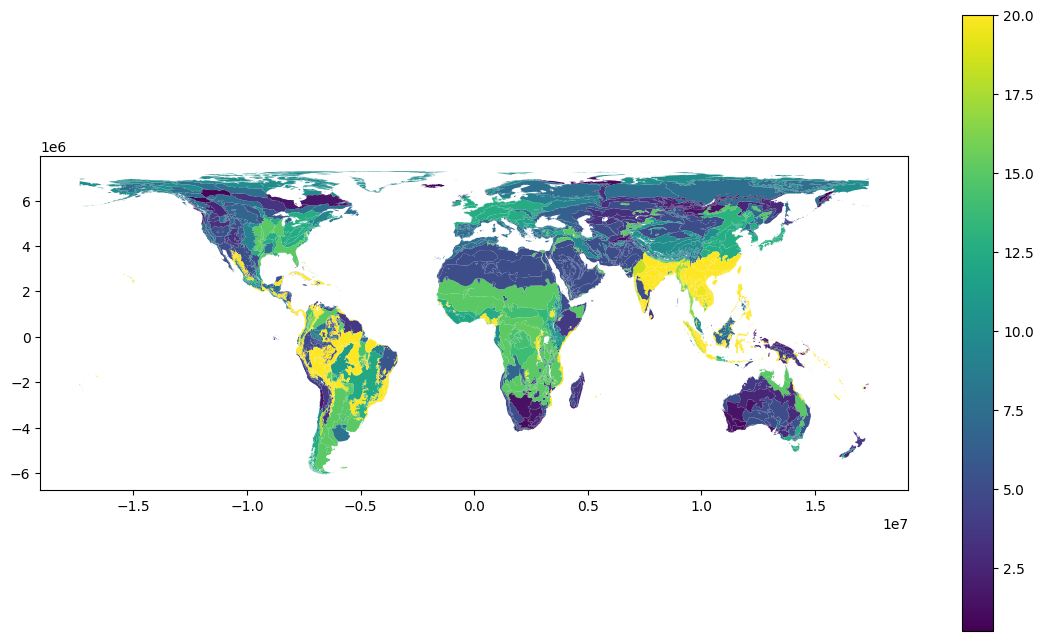

In [ ]:
SO2_eq_th.plot(column="Threshold", legend = True, figsize = (14,8))


<Axes: >

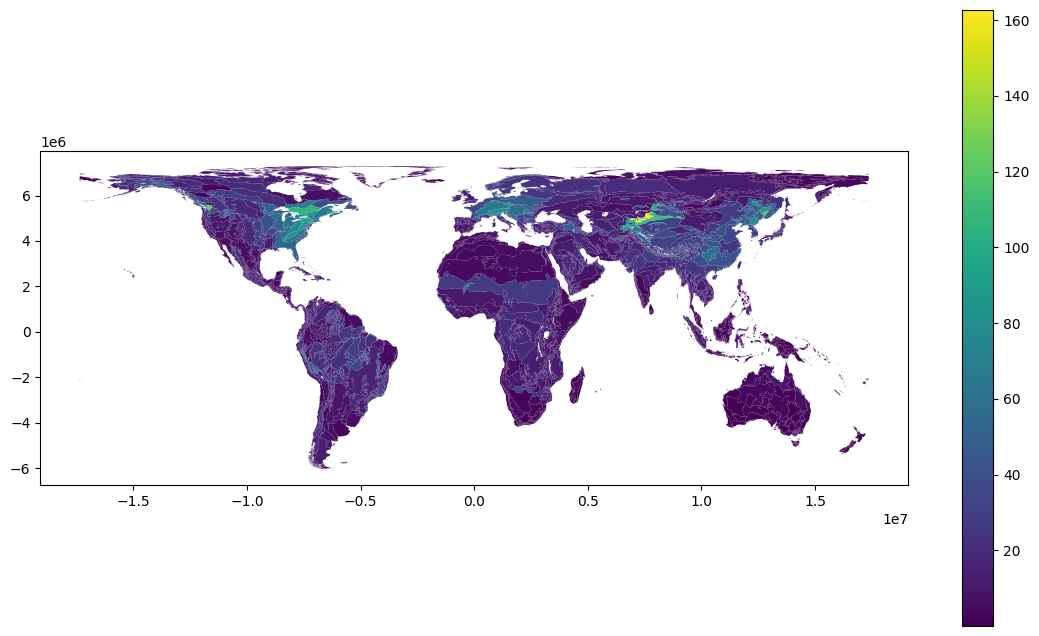

In [ ]:
SO2_eq_th.plot(column="N_th_so2", legend = True, figsize = (14,8))

It can be seen that targets change, as the LEAFs can have significantly different values. This could mean that we keep treating, up to target setting, targets in their original form

#### Target over Baseline Ratio
As targets are relative to their own ecoregion, it's important to keep the Target over Baseline Ratio, so the same ecoregions lead to the same conclusions. This should happen as the same linear transformation is being applied to both target and baseline, but it should be checked nevertheless.

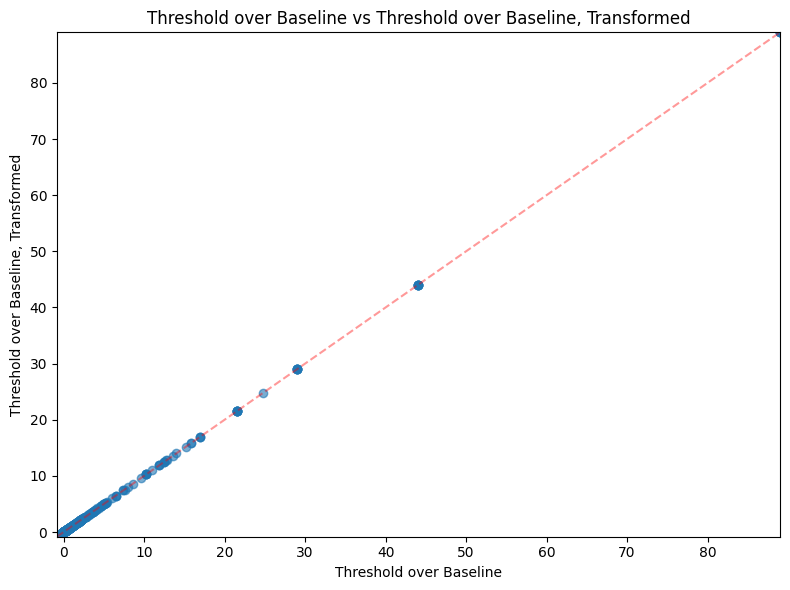

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Keep only finite pairs (no NaN, no Inf)
mask = np.isfinite(SO2_eq_th["TB_distance"]) & np.isfinite(SO2_eq_th["TB_distance_SO2"])
x = SO2_eq_th.loc[mask, "TB_distance"]
y = SO2_eq_th.loc[mask, "TB_distance_SO2"]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)

plt.xlabel("Threshold over Baseline")
plt.ylabel("Threshold over Baseline, Transformed")
plt.title("Threshold over Baseline vs Threshold over Baseline, Transformed")

# Compute clean limits
lims = [min(x.min(), y.min()), max(x.max(), y.max())]

# 1:1 line
plt.plot(lims, lims, color="red", linewidth=1.5, alpha=0.4, linestyle='--')

plt.xlim(lims)
plt.ylim(lims)

plt.tight_layout()
plt.show()


Which shows there's a 1:1 relationship.

Plotting the maps

c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:942: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:972: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


<Axes: >

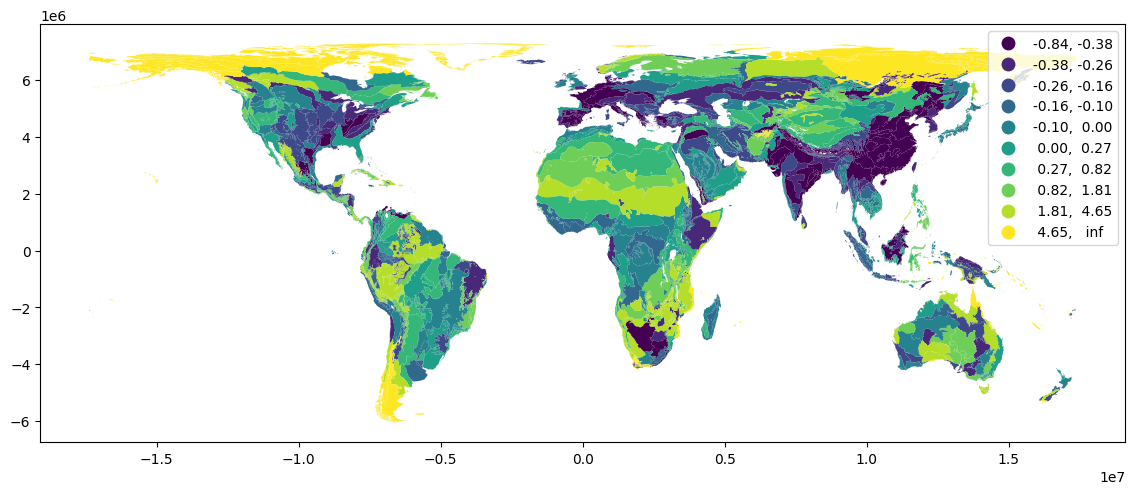

In [ ]:
SO2_eq_th.plot(column="TB_distance", legend = True, figsize = (14,8), scheme="Quantiles", k = 10)

c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:942: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\mapclassify\classifiers.py:972: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


<Axes: >

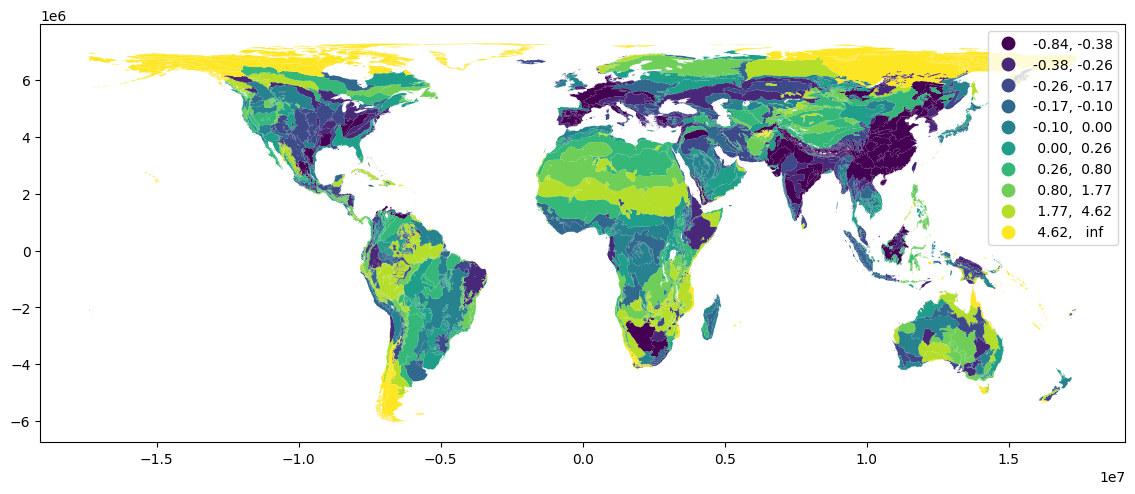

In [ ]:
SO2_eq_th.plot(column="TB_distance_SO2", legend = True, figsize = (14,8), scheme="Quantiles", k = 10)

<Axes: >

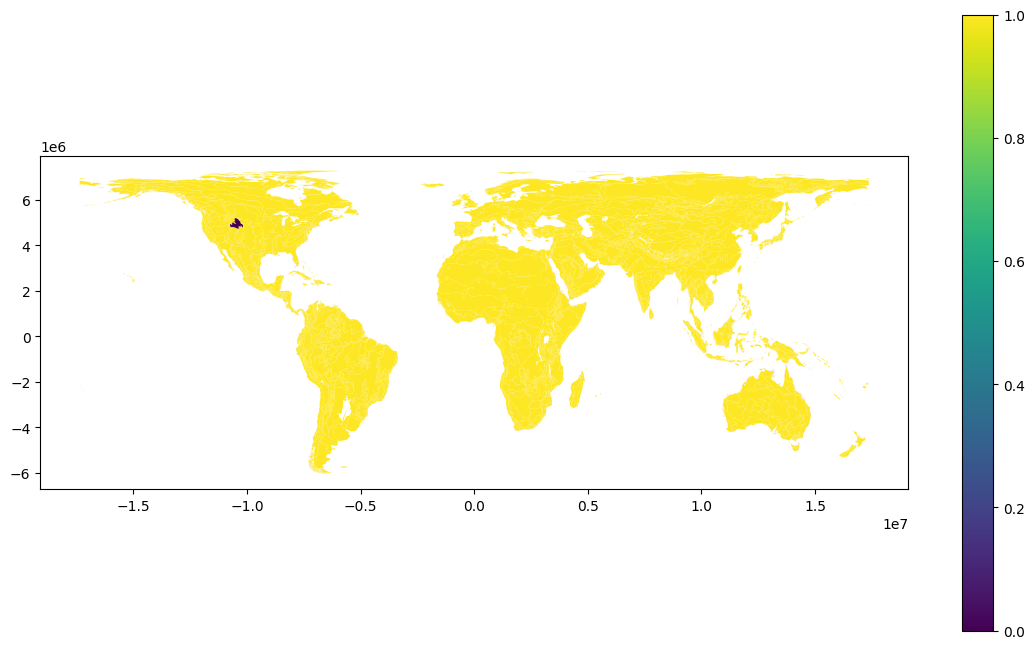

In [ ]:
SO2_eq_th.plot(column="TBD_ratio", legend = True, figsize = (14,8))

Which look the same and it's ok!